# Business Problem:
One of the global banks would like to understand what factors driving credit card spend are. The bank want use these insights to calculate credit limit. In order to solve the problem, the bank conducted survey of 5000 customers and collected data.
The objective of this case study is to understand what's driving the total spend (Primary Card + Secondary card). Given the factors, predict credit limit for the new applicants
# Data Availability:
 Data for the case are available in xlsx format.

 The data have been provided for 5000 customers.

 Detailed data dictionary has been provided for understanding the data in the data.

 Data is encoded in the numerical format to reduce the size of the data however some of the variables are categorical. You can find the details in the data dictionary

In [1]:
# for data handling and profiling
import pandas as pd
import numpy as np
import pandas_profiling

# for charts
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for stats test
import scipy.stats as stats
import statsmodels.formula.api as smf

In [2]:
# predictive modelling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from patsy import dmatrices
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [3]:
#feature engineering
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
data=pd.read_excel('D:/Pyhton/Advance case studies/1Predicting Credit Card Spend and Identifying Key Drivers/Data Set.xlsx')

In [5]:
data.head(2)

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0


In [6]:
# Assumpton check: no of variables should be less than no of observation
data.shape

(5000, 130)

In [7]:
#calculate total spend
data['Total_Spend'] = data.cardspent + data.card2spent
data.drop(['cardspent', 'card2spent'], axis = 1, inplace = True)

## Create UDFs

In [8]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [9]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [10]:
# Missing value imputation for continuous variables
def missing_imputation_conti(x, stats = 'mean'):
    if stats == 'mean':
        x = x.fillna(x.mean())
    else:
        x = x.fillna(x.mode())
    return x

In [11]:
# Missing value imputation for categorical variables
def missing_imputation_cat(x):
    mod = x.mode()
    x = x.fillna(mod[0])
    return x

In [12]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### Exporting pandas profiling output to html file

In [13]:
report = pandas_profiling.ProfileReport(data)

In [14]:
report.to_file(output_file = 'D:/Pyhton/Advance case studies/1Predicting Credit Card Spend and Identifying Key Drivers/profilereport.html')

### Basic Exploratory Analysis

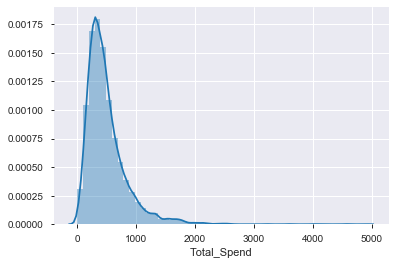

In [15]:
## Assumpton check: the distribution of Y varibale should be normal distributon
sns.distplot(data.Total_Spend)
plt.show()

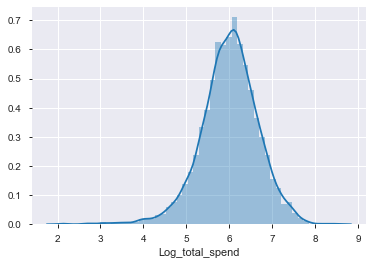

In [16]:
data['Log_total_spend'] = np.log(data['Total_Spend'])
sns.distplot(data.Log_total_spend)
plt.show()

#### After taking log the distribution seems much like a normal distributon, hence using log of dependent variable(Y) as model input

In [18]:
#Identify categorical variable list as per data dictionary
cat_vars = ['region','townsize','gender','agecat','birthmonth','edcat','jobcat','union','employ','empcat','retire','inccat',
            'default','jobsat','marital','spousedcat','homeown','hometype','address','addresscat','cars','carown','cartype',
            'carcatvalue','carbought','carbuy','commute','commutecat','commutecar','commutemotorcycle','commutecarpool',
            'commutebus','commuterail','commutepublic','commutebike','commutewalk','commutenonmotor','telecommute','reason',
            'polview','polparty','polcontrib','vote','card','cardtype','cardbenefit','cardfee','cardtenure','cardtenurecat',
            'card2','card2type','card2benefit','card2fee','card2tenure','card2tenurecat','active','bfast','churn','tollfree',
            'equip','callcard','wireless','multline','voice','pager','internet','callid','callwait','forward','confer','ebill',
            'owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax','news','response_01','response_02',
            'response_03']


In [19]:
#Continuous variables list
conti_vars =list(data.columns.difference(cat_vars))

In [20]:
data_conti_vars=data[conti_vars]
#dropping customer id as it would not be required for modelling
data_conti_vars.drop(['custid','Total_Spend'],inplace=True,axis=1)

In [21]:
data_cat_vars=data[cat_vars]

In [22]:
# alternate of .describe() for continuous variables
data_conti_vars.apply(continuous_var_summary).T.round(1)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Log_total_spend,5000.0,0.0,30006.2,6.0,6.0,0.7,0.5,2.1,4.1,4.9,5.2,5.6,6.0,6.4,6.8,7.0,7.5,8.5
age,5000.0,0.0,235128.0,47.0,47.0,17.8,315.8,18.0,18.0,20.0,23.0,31.0,47.0,62.0,72.0,76.0,79.0,79.0
cardmon,5000.0,0.0,77219.2,15.4,13.8,15.0,225.2,0.0,0.0,0.0,0.0,0.0,13.8,22.8,34.0,42.0,64.2,188.5
cardten,4998.0,2.0,3600951.0,720.5,425.0,922.2,850499.9,0.0,0.0,0.0,0.0,0.0,425.0,1080.0,1871.5,2455.7,4011.2,13705.0
carvalue,5000.0,0.0,116162.9,23.2,17.0,21.2,450.8,-1.0,-1.0,-1.0,2.5,9.2,17.0,31.1,52.9,72.0,92.0,99.6
commutetime,4998.0,2.0,126677.0,25.3,25.0,5.9,34.6,8.0,13.0,16.0,18.0,21.0,25.0,29.0,33.0,35.0,40.0,48.0
creddebt,5000.0,0.0,9286.6,1.9,0.9,3.4,11.7,0.0,0.0,0.1,0.2,0.4,0.9,2.1,4.3,6.4,14.3,109.1
debtinc,5000.0,0.0,49770.8,10.0,8.8,6.4,41.0,0.0,0.7,1.9,2.8,5.1,8.8,13.6,18.6,22.2,29.2,43.1
ed,5000.0,0.0,72715.0,14.5,14.0,3.3,10.8,6.0,8.0,9.0,10.0,12.0,14.0,17.0,19.0,20.0,21.0,23.0
equipmon,5000.0,0.0,64956.6,13.0,0.0,19.2,369.1,0.0,0.0,0.0,0.0,0.0,0.0,30.8,42.7,49.1,63.3,106.3


In [23]:
# alternate of .describe() for categorical variables
data_cat_vars.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
region,5000,0,5,1027,20.54
townsize,4998,2,1,1436,28.73
gender,5000,0,1,2518,50.36
agecat,5000,0,4,1222,24.44
birthmonth,5000,0,September,458,9.16
edcat,5000,0,2,1567,31.34
jobcat,5000,0,2,1640,32.8
union,5000,0,0,4244,84.88
employ,5000,0,0,659,13.18
empcat,5000,0,2,1180,23.6


### Dropping duplicate, insignificant, low cardinality variables

In [24]:
#Drop Columns with more than 25% null values
data_conti_vars.drop(['lnwiremon','lnwireten','lnequipten','lnequipmon','lntollmon','lntollten','lncardten','lncardmon']
                     ,inplace = True
                     ,axis=1)

In [25]:
#dropping birthmonth as it is not useful for model
data_cat_vars.drop(['birthmonth'],inplace=True,axis=1)

In [26]:
# Droping duplicate variables where both log and non-log values are present
data_conti_vars.drop(['lninc','lncreddebt','lnothdebt','lnlongmon','lnlongten']
                     ,inplace = True
                     ,axis=1)

In [27]:
# Droping duplicate categorical variables where both categorical and continuos variables are present
data_cat_vars.drop(['agecat','edcat','empcat','inccat','spousedcat','addresscat','carcatvalue','commutecat','cardtenurecat',
                     'card2tenurecat']
                     ,inplace = True
                     ,axis=1)


In [28]:
#dropping insignificant columns for model buildng
data_conti_vars.drop(columns = ['pets_birds', 'pets_cats', 'pets_dogs', 'pets_freshfish', 'pets_reptiles', 'pets_saltfish', 'pets_small'],
                 axis = 1, 
              inplace = True)

In [29]:
#dropping low variance columns, more than 80% of the values are same
data_cat_vars.drop(['owntv','commutenonmotor','owncd','response_01','ownvcr','owndvd','commutepublic','commutemotorcycle',
                    'response_03','commutebike','response_02','retire','union','ownfax','card2fee','telecommute','reason',
                    'cardfee'], axis = 1, inplace = True)


### Outlier Treatment

In [30]:
data_conti_vars = data_conti_vars.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), 
                                                         upper = x.quantile(0.99)))

### missing Value treatments

In [31]:
data_conti_vars = data_conti_vars.apply(missing_imputation_conti)
data_cat_vars = data_cat_vars.apply(missing_imputation_cat)

In [32]:
data_tree = pd.concat([data_conti_vars, data_cat_vars], axis = 1)

### creating dummy for non-ordinal categorical variables

In [33]:
dummy_var=['region','card','cardtype','cardbenefit','card2','card2type','card2benefit','bfast','internet','jobcat']
for c_feature in dummy_var:
    data_cat_vars[c_feature] = data_cat_vars[c_feature].astype('category')
    data_cat_vars = create_dummies(data_cat_vars, c_feature)

### Final data set for analysis and model building

In [34]:
data_new = pd.concat([data_conti_vars, data_cat_vars], axis = 1)

### Checking co-linearity between valiables

In [35]:
# Checking co-linearity 
corrm = data_new.corr()
corrm.to_excel('D:/Pyhton/Advance case studies/1Predicting Credit Card Spend and Identifying Key Drivers/CreditCard_corrm.xlsx')

## Feature Selection Based on Univariate F-Test (ANOVA)

This is Univariate linear regression tests, for testing the individual effect of each of many regressors.

This is internally done in 2 steps:

1. The correlation between each regressor and the target is computed, that is, ((X[:, i] - mean(X[:, i])) * (y - mean_y)) / (std(X[:, i]) * std(y)).
2. It is converted to an F score then to a p-value.

In [36]:
#split the X and Y variables for model building
X = data_new[data_new.columns.difference(['Log_total_spend'])]
Y = data_new.Log_total_spend

In [37]:
F_values, p_values  = f_regression(X, Y )

In [38]:
f_reg_results = pd.concat([pd.Series(X.columns, name = 'Variable'), 
                               pd.Series(F_values, name = 'F_Value'), 
                                   pd.Series(p_values, name = 'P_Value').round(5)], axis =  1)

In [39]:
m_variables=f_reg_results.sort_values(by = 'P_Value')
m_variables.head(4)

,Variable,F_Value,P_Value
51,ed,48.542970,0.0
23,card_4,26.838527,0.0
34,carown,27.674974,0.0
37,carvalue,519.265491,0.0


In [40]:
#selecting important features based on p-value
m_features = m_variables.Variable[m_variables.P_Value <= 0.05]

In [41]:
X=data_new[m_features]

In [42]:
X.shape

(5000, 59)

## Variable Reduction Using RFE (Recursive Feature Elimination)

In [43]:
rfe = RFE(LinearRegression(), 25).fit(X, Y)
rfe.ranking_

array([ 8,  1,  1, 25,  1, 23, 15, 19, 35,  1,  1, 10, 13, 22, 18,  1, 26,
       30,  1,  1,  1, 31,  1,  1,  1,  2, 16,  3,  1,  1, 20, 32, 21, 17,
       24,  7,  1,  1, 27,  1,  1,  9,  1, 11,  6,  1,  5, 12,  4,  1, 28,
       34,  1,  1,  1, 29, 14,  1, 33])

In [44]:
rnk = pd.DataFrame({'Features' : list(X.columns),
              'Ranking'  : rfe.ranking_})

In [45]:
X.columns[rfe.support_]

Index(['card_4', 'carown', 'creddebt', 'card_3', 'gender', 'ownpda',
       'wireless', 'homeown', 'card_2', 'card2_2', 'card2_3', 'card2_4',
       'internet_4', 'vote', 'card2_5', 'forward', 'card_5', 'internet_3',
       'voice', 'jobcat_3', 'bfast_2', 'polcontrib', 'ebill', 'card2benefit_3',
       'region_5'],
      dtype='object')

In [46]:
rfe_X = X[X.columns[rfe.support_]]
rfe_X.head(4)

,card_4,carown,creddebt,card_3,gender,ownpda,wireless,homeown,card_2,card2_2,...,forward,card_5,internet_3,voice,jobcat_3,bfast_2,polcontrib,ebill,card2benefit_3,region_5
0,0,1,1.200909,1,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,0,1,1.222020,0,0,1,1,1,1,0,...,1,0,0,1,0,0,0,1,1,1
2,0,1,0.928620,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0.033160,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0


## Variable Reduction Using Select K-Best Technique

In [47]:
kbest = SelectKBest(f_regression, k = 25).fit(X, Y)

In [48]:
score = pd.DataFrame({'Features' : X.columns,
                  'Scores'   : kbest.scores_})
score.sort_values(by = 'Scores', ascending = False)[:25]

,Features,Scores
11,income,724.662079
3,carvalue,519.265491
14,othdebt,363.647212
4,creddebt,287.876986
20,card_2,72.100414
9,card_3,61.980089
0,ed,48.542970
21,wireten,47.981139
5,wiremon,38.275030
23,card2_3,37.936645


In [49]:
X.columns[kbest.get_support()]

Index(['ed', 'card_4', 'carown', 'carvalue', 'creddebt', 'wiremon', 'employ',
       'equipmon', 'equipten', 'card_3', 'gender', 'income', 'jobcat_2',
       'jobsat', 'othdebt', 'ownpda', 'tollmon', 'tollten', 'wireless',
       'homeown', 'card_2', 'wireten', 'card2_2', 'card2_3', 'card2_4'],
      dtype='object')

In [50]:
kbest_X = X[X.columns[kbest.get_support()]]
kbest_X.head(4)

,ed,card_4,carown,carvalue,creddebt,wiremon,employ,equipmon,equipten,card_3,...,ownpda,tollmon,tollten,wireless,homeown,card_2,wireten,card2_2,card2_3,card2_4
0,15,0,1,14.3,1.200909,0.00,0,29.50,126.1,1,...,0,29.0,161.05,0,0,0,0.00,0,0,0
1,17,0,1,6.8,1.222020,45.65,0,54.85,1975.0,0,...,1,0.0,0.00,1,1,1,1683.55,0,0,1
2,14,0,1,18.8,0.928620,0.00,16,0.00,0.0,0,...,0,0.0,0.00,0,1,1,0.00,0,0,1
3,16,0,1,8.7,0.033160,0.00,0,0.00,0.0,0,...,0,0.0,0.00,0,1,1,0.00,0,1,0


## Applying VIF (Variance Inflation Factor)

In [51]:
#consider all the X variables marked as important by both the methods i.e. RFE and K-best
X = pd.concat([kbest_X,rfe_X], axis = 1)
X = X.loc[:,~X.columns.duplicated()]
X.shape

(5000, 38)

In [52]:
prams = 'Log_total_spend ~ ' + ' + '.join(X.columns)
prams

'Log_total_spend ~ ed + card_4 + carown + carvalue + creddebt + wiremon + employ + equipmon + equipten + card_3 + gender + income + jobcat_2 + jobsat + othdebt + ownpda + tollmon + tollten + wireless + homeown + card_2 + wireten + card2_2 + card2_3 + card2_4 + internet_4 + vote + card2_5 + forward + card_5 + internet_3 + voice + jobcat_3 + bfast_2 + polcontrib + ebill + card2benefit_3 + region_5'

In [53]:
model_data=X.copy()
model_data['Log_total_spend']=Y
# separate the Y and X variables
y, x = dmatrices(prams, model_data, return_type = 'dataframe')

# For each x, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = x.columns
vif['VIF Factor'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

# display the output
vif_features = vif.round(1).sort_values('VIF Factor', ascending = False)
vif_features

,Features,VIF Factor
0,Intercept,61.4
6,wiremon,21.7
22,wireten,11.3
17,tollmon,8.5
18,tollten,8.3
19,wireless,7.4
8,equipmon,7.0
9,equipten,6.1
12,income,5.7
4,carvalue,5.5


In [54]:
#taking cut off at 6, beyond which variables are highly colinear
X = X[vif_features[(vif_features['VIF Factor'] < 6)].Features]

In [55]:
X.shape

(5000, 31)

## Apply Transformation On Numeric Variables

Apply transformation on numeric variables(log, sqrt, square, exp) and identify which transformation gives best correlation between dependent and independent variables.

In [56]:
def check_correlation(x):
    a = Y.corr(x)
    b = Y.corr(np.log(x+1))
    c = Y.corr(np.sqrt(x))
    d = Y.corr(np.square(x))
    f = Y.corr(np.exp(x))
    return pd.Series([a, b, c, d, f], index = ['x','log x','sqrt x','square x','exp x'])
    
correlation = X.apply(check_correlation).T
correlation.to_excel('D:/Pyhton/Advance case studies/1Predicting Credit Card Spend and Identifying Key Drivers/Transform_var_corr1.xlsx')

In [57]:
#Based on best correlation applying transformations on numeric variables before input to the model
#log transform
X['log_income'] = X['income'].apply(lambda x:np.log(x+1))
X['log_othdebt'] = X['othdebt'].apply(lambda x:np.log(x+1))
X['log_employ'] = X['employ'].apply(lambda x:np.log(x+1))
X['log_creddebt'] = X['creddebt'].apply(lambda x:np.log(x+1))

#sqrt transform
X['sqrt_carvalue'] = X['carvalue'].apply(lambda x:np.sqrt(x+1))
X['sqrt_carown'] = X['carown'].apply(lambda x:np.sqrt(x+1))

#X['square_equipten'] = X['equipten'].apply(lambda x:np.square(x+1))
#drop original variables
X.drop(['income','othdebt','creddebt','employ','carvalue','carown']
       ,axis=1
       ,inplace=True)

In [58]:
X.shape

(5000, 31)

### Split Train/Test 70:30

In [59]:
model_data=X.copy()
model_data['Log_total_spend']=Y

In [60]:
train, test = train_test_split( model_data,test_size = 0.3,random_state = 500 )

In [61]:
# verify the no of obs in training and testing after split
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  3500  |  No of obs in testing:  1500


In [62]:
train.Log_total_spend.mean()

5.996814306510669

In [63]:
test.Log_total_spend.mean()

6.023188741055472

## Building Linear Regression Model using OLS and check model params

In [64]:
prams = 'Log_total_spend ~ ' + ' + '.join(X.columns)
prams

'Log_total_spend ~ card2_4 + card_4 + card2_3 + card2_2 + card_2 + voice + card_3 + forward + ownpda + ebill + ed + internet_4 + card2_5 + card_5 + jobcat_2 + jobsat + internet_3 + bfast_2 + jobcat_3 + gender + vote + homeown + polcontrib + card2benefit_3 + region_5 + log_income + log_othdebt + log_employ + log_creddebt + sqrt_carvalue + sqrt_carown'

In [575]:
lm = smf.ols(prams, train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        Log_total_spend   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     56.84
Date:                Mon, 27 Jan 2020   Prob (F-statistic):          1.79e-281
Time:                        04:22:07   Log-Likelihood:                -2683.8
No. Observations:                3500   AIC:                             5432.
Df Residuals:                    3468   BIC:                             5629.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.5499      0.110     50.

In [576]:
#removing features with very high P value, as they would not be significant for model

lm = smf.ols('Log_total_spend ~ card2_4 + card_4 + card2_3 + card2_2 + card_2 + card_3 + ed + internet_4 + card2_5 + card_5 + jobcat_2 + internet_3 + gender + card2benefit_3 + region_5 + log_income + log_employ + sqrt_carvalue + sqrt_carown'
, train).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        Log_total_spend   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     92.28
Date:                Mon, 27 Jan 2020   Prob (F-statistic):          1.29e-290
Time:                        04:30:07   Log-Likelihood:                -2688.7
No. Observations:                3500   AIC:                             5417.
Df Residuals:                    3480   BIC:                             5541.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.5559      0.106     52.

### Model params
R-squared:                       0.335
Adj. R-squared:                  0.331

P value for all variable is low, hence they are significant X variables, which are responsible for the variation in Y

### Prediction and model validation for OLS

In [577]:
# actual spend of training and testing/validation data
train['actual_spend'] = np.exp(train.Log_total_spend)
test['actual_spend'] = np.exp(test.Log_total_spend)

In [578]:
# predict spend on the training and testing/validation data
train['pred_spend'] = np.exp(lm.predict(train))
test['pred_spend'] = np.exp(lm.predict(test))

In [579]:
# accuracy metrics (MAPE: Mean Absolute Percentage Error)
MAPE_train = np.mean(np.abs(train['actual_spend'] - train['pred_spend']) / train['actual_spend'])
MAPE_test = np.mean(np.abs(test['actual_spend'] - test['pred_spend']) / test['actual_spend'])

print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.47046450101458076  |  MAPE of testing data:  0.47957878213975846


In [582]:
# accuracy metrics (RMSE: Root Mean Squared Error)
RMSE_train = np.sqrt(mean_squared_error(train.actual_spend ,train.pred_spend)).round(3)
RMSE_test = np.sqrt(mean_squared_error(test.actual_spend ,test.pred_spend)).round(3)

# print the values of RMSE for train and test
print('RMSE of training data: ', RMSE_train,  ' | ', 'RMSE of testing data: ', RMSE_test)

RMSE of training data:  264.414  |  RMSE of testing data:  283.204


In [583]:
# accuracy metrics (Correlation)
Corr_train = stats.stats.pearsonr(train.actual_spend ,train.pred_spend)
Corr_test = stats.stats.pearsonr(test.actual_spend, test.pred_spend)

# print the values of Correlation for train and test
print('Correlation of training data: ', Corr_train,  ' | ', 'Correlation of testing data: ', Corr_test)

Correlation of training data:  (0.5894198043384132, 0.0)  |  Correlation of testing data:  (0.5610122434627409, 4.1945986414099897e-125)


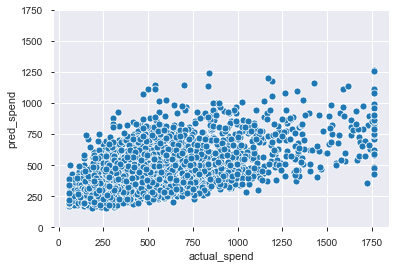

In [587]:
sns.scatterplot(train.actual_spend, train.pred_spend)
plt.yticks([0, 250, 500,750,1000,1250,1500,1750])
plt.show()

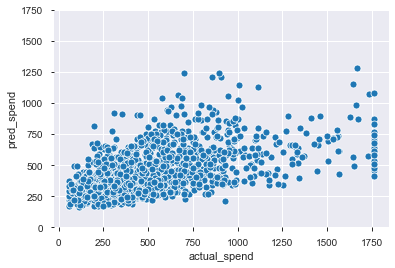

In [588]:
sns.scatterplot(test.actual_spend, test.pred_spend)
plt.yticks([0, 250, 500,750,1000,1250,1500,1750])
plt.show()

### Decile Analysis

In [589]:
# create the 10 groups in the data
train['Deciles'] = pd.qcut(train['pred_spend'], 10, labels = False)
test['Deciles'] = pd.qcut(test['pred_spend'], 10, labels = False)

In [590]:
# Decile Analysis for train data
Predicted_avg = train[['Deciles', 'pred_spend']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred_spend']
Actual_avg = train[['Deciles', 'actual_spend']].groupby(train.Deciles).mean().sort_index(ascending = False)['actual_spend']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Decile Analysis for test data
Predicted_avg = test[['Deciles', 'pred_spend']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_spend']
Actual_avg = test[['Deciles', 'actual_spend']].groupby(test.Deciles).mean().sort_index(ascending = False)['actual_spend']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# write the data into the file
Decile_analysis_train.to_csv('D:/Pyhton/Advance case studies/1Predicting Credit Card Spend and Identifying Key Drivers/Decile_analysis_train.csv')
Decile_analysis_test.to_csv('D:/Pyhton/Advance case studies/1Predicting Credit Card Spend and Identifying Key Drivers/Decile_analysis_test.csv')

In [591]:
Decile_analysis_train

,Deciles,pred_spend,actual_spend
0,9,811.029653,912.850530
1,8,605.851937,667.597266
2,7,521.875102,577.552800
3,6,458.813095,509.746812
4,5,407.696571,481.051027
5,4,368.335113,413.820800
6,3,335.949097,386.877529
7,2,305.538903,354.929344
8,1,275.525468,321.103888
9,0,226.103074,258.635612


In [592]:
Decile_analysis_test

,Deciles,pred_spend,actual_spend
0,9,819.541284,898.770382
1,8,616.790541,752.707672
2,7,523.761426,585.008177
3,6,457.998161,520.780095
4,5,408.812186,494.292814
5,4,366.796537,465.780051
6,3,335.721258,406.379451
7,2,308.675044,325.924019
8,1,277.202193,339.042901
9,0,223.823309,262.770805


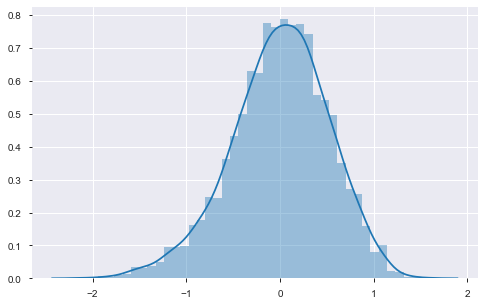

In [593]:
# check Normality of the residuals/error (using distplot)
plt.figure(figsize = (8, 5))
sns.distplot(lm.resid)
plt.show()

#### Errors are normaly distributes. This can be seen in the residual plot graphs

In [596]:
# check mean of residuals/errors is zero or not
print(lm.resid.mean())

1.9480544161914233e-14


It is very close to zero

In [602]:
# assumption: residuals/errors of the model should not be correlated with dependant (Y) variable
print(stats.stats.pearsonr(lm.resid, train.actual_spend))

(0.7077470648059704, 0.0)


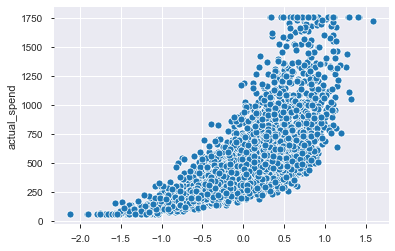

In [603]:
# assumption: homoscedasticity of residuals/errors
sns.scatterplot(lm.resid, train.actual_spend)
plt.show()

### Errors are increasing along with the value of Y

What can be the possible reasons for poor model performance?
1. Small sample 
2. Assumptions of linear/regression modelling are not true for the model in consideration

Try with other modelling techniques to check if better performance can be achieved. For this using the attributes left after basic cleaning but before any feature engineering using RFE, K-Best or VIF

## Decision Tree (DT)

In [605]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict

In [656]:
data_tree.columns

Index(['Log_total_spend', 'age', 'cardmon', 'cardten', 'carvalue',
       'commutetime', 'creddebt', 'debtinc', 'ed', 'equipmon', 'equipten',
       'hourstv', 'income', 'longmon', 'longten', 'othdebt', 'pets', 'reside',
       'spoused', 'tenure', 'tollmon', 'tollten', 'wiremon', 'wireten',
       'region', 'townsize', 'gender', 'jobcat', 'employ', 'default', 'jobsat',
       'marital', 'homeown', 'hometype', 'address', 'cars', 'carown',
       'cartype', 'carbought', 'carbuy', 'commute', 'commutecar',
       'commutecarpool', 'commutebus', 'commuterail', 'commutewalk', 'polview',
       'polparty', 'polcontrib', 'vote', 'card', 'cardtype', 'cardbenefit',
       'cardtenure', 'card2', 'card2type', 'card2benefit', 'card2tenure',
       'active', 'bfast', 'churn', 'tollfree', 'equip', 'callcard', 'wireless',
       'multline', 'voice', 'pager', 'internet', 'callid', 'callwait',
       'forward', 'confer', 'ebill', 'ownpda', 'ownpc', 'ownipod', 'owngame',
       'news'],
      dtype='obj

In [65]:
X = data_tree[data_tree.columns.difference(['Total_Spend', 'Log_total_spend'])]
Y = data_tree['Log_total_spend']
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.3, random_state = 8945)

In [659]:
# Search best param using cross validation
max_depth_range = range(2, 8)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=345)
    
    MSE_scores = cross_val_score(treereg, train_X, train_Y, cv=10, scoring='neg_mean_squared_error',verbose=0)
    
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
print(RMSE_scores)

[0.5686526360437425, 0.5491533718507414, 0.5419387264262072, 0.5526829004366796, 0.5751236106666622, 0.5980970787372859]


Text(0, 0.5, 'RMSE (lower is better)')

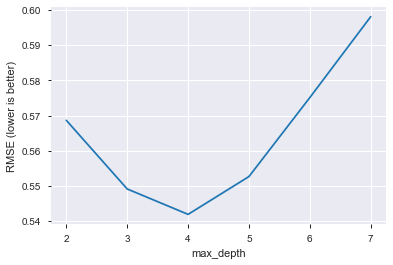

In [660]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [662]:
# max_depth=4 was best, so fit a tree using that parameter
treereg = DecisionTreeRegressor(max_depth=4, random_state=345)
treereg.fit(train_X, train_Y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=345, splitter='best')

In [663]:
metrics.mean_squared_error(train_Y, treereg.predict(train_X))

0.2821872700778854

In [664]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature' : X.columns, 'importance' : treereg.feature_importances_})

,feature,importance
0,active,0.000000
1,address,0.000000
2,age,0.000000
3,bfast,0.000000
4,callcard,0.000000
5,callid,0.000000
6,callwait,0.000000
7,carbought,0.000000
8,carbuy,0.000000
9,card,0.380462


In [665]:
scores = cross_val_score(treereg, train_X, train_Y, cv = 10, scoring = 'r2')
scores

array([0.2755289 , 0.30645187, 0.30883246, 0.29020921, 0.28871548,
       0.24028802, 0.29042052, 0.23995203, 0.32162998, 0.29475621])

In [666]:
np.mean(scores)

0.2856784687644831

In [667]:
#prediction for test data
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, treereg.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, treereg.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, treereg.predict(test_X))))

Mean Absolute Error: 0.4267499538724469
Mean Squared Error: 0.293504091718437
Root Mean Squared Error: 0.54176017915535


In [668]:
print("R-squared for Train:" ,treereg.score(train_X, train_Y))
print("R-squared for Test: ", treereg.score(test_X, test_Y))

R-squared for Train: 0.3172113375181417
R-squared for Test:  0.30443268793821765


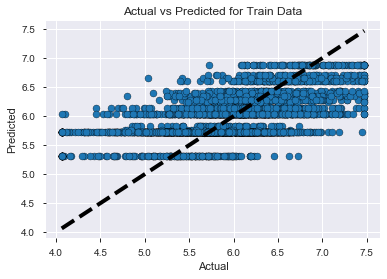

In [669]:
fig, ax = plt.subplots()
ax.scatter(train_Y, treereg.predict(train_X), edgecolors = (0, 0, 0))
ax.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

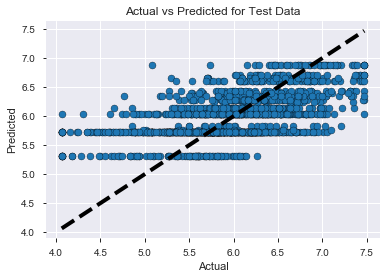

In [670]:
fig, ax = plt.subplots()
ax.scatter(test_Y, treereg.predict(test_X), edgecolors=(0, 0, 0))
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

## Random Forest (RF)

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [671]:
pargrid_rf = {'n_estimators': (10, 50, 100), 'max_depth': range(3,6)}

In [672]:
gscv_rf = GridSearchCV(estimator = RandomForestRegressor(), 
                       param_grid = pargrid_rf, 
                       cv = 5, 
                       verbose = 0, 
                       n_jobs = -1)
    
gscv_result = gscv_rf.fit(train_X, train_Y)

In [673]:
gscv_result.best_params_

{'max_depth': 4, 'n_estimators': 50}

In [674]:
gscv_rf.best_score_

0.2969930415291839

In [675]:
#building the RF model based on best params
RF = RandomForestRegressor(max_depth = 4, n_estimators = 50, random_state = 0, n_jobs = -1)  
RF.fit(train_X, train_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [676]:
radm_test_pred = pd.DataFrame({ 'actual': test_Y, 'predicted': RF.predict(test_X)})

In [677]:
scores = cross_val_score(RF, train_X, train_Y, cv=5, scoring='r2')
scores

array([0.28988438, 0.31562239, 0.27650721, 0.28121852, 0.32308374])

In [678]:
np.mean(scores)

0.29726324850663877

In [679]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, RF.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, RF.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, RF.predict(test_X))))

Mean Absolute Error: 0.4225639740436753
Mean Squared Error: 0.2882634123348765
Root Mean Squared Error: 0.5369016784615936


In [680]:
print("R-squared for Train:" ,RF.score(train_X, train_Y))
print("R-squared for Test: ", RF.score(test_X, test_Y))

R-squared for Train: 0.33309204150145577
R-squared for Test:  0.3168524305416621


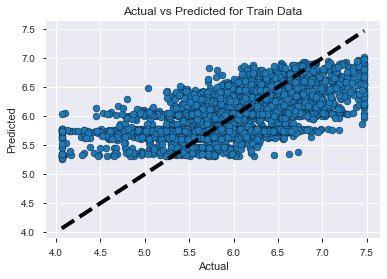

In [681]:
fig, ax = plt.subplots()
ax.scatter(train_Y, RF.predict(train_X), edgecolors = (0, 0, 0))
ax.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

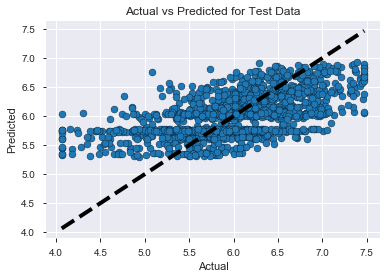

In [682]:
fig, ax = plt.subplots()
ax.scatter(test_Y, RF.predict(test_X) , edgecolors = (0, 0, 0))
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

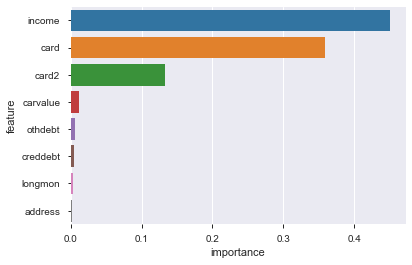

In [701]:
#important features as per RF
indices = np.argsort(RF.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_X.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_X.columns[indices[f]],
                         RF.feature_importances_[indices[f]]]
sns.barplot( y = 'feature', x = 'importance', data = feature_rank.head(8) )

## Gradient Boosting (GBM)


In [66]:
from sklearn.ensemble import GradientBoostingRegressor

In [69]:
#search for best model params
pargrid_gbmr = {'n_estimators': [50, 75, 100, 150],
               'learning_rate': [10 ** x for x in range(-2, 1)],
                'max_features': [11, 12,13, 14, 15]}

gscv_gbmr = GridSearchCV(estimator = GradientBoostingRegressor(), 
                        param_grid = pargrid_gbmr, 
                        cv = 5,
                        verbose = True, n_jobs = -1)

In [70]:
gscv_result = gscv_gbmr.fit(train_X, train_Y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   35.0s finished


In [71]:
gscv_result.best_params_

{'learning_rate': 0.1, 'max_features': 15, 'n_estimators': 75}

In [72]:
gscv_result.best_score_

0.29568278747408766

In [73]:
#build the model based on best params:
gscv_gbmr = GradientBoostingRegressor(n_estimators = 75, learning_rate = 0.1, max_depth = 15)
gscv_gbmr.fit(train_X, train_Y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=75,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [74]:
scores = cross_val_score(gscv_gbmr, train_X, train_Y, cv = 10, scoring = 'r2')
scores

array([-0.00519089,  0.05548881,  0.05714957,  0.02001091, -0.07995899,
       -0.02055324,  0.16257187, -0.07891392,  0.08211295,  0.10804301])

In [75]:
np.mean(scores)

0.030076007724316546

In [76]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, gscv_gbmr.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, gscv_gbmr.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, gscv_gbmr.predict(test_X))))

Mean Absolute Error: 0.49090800277013596
Mean Squared Error: 0.3860379475272437
Root Mean Squared Error: 0.6213195212829254


In [77]:
print("R-squared for Train:" ,gscv_gbmr.score(train_X, train_Y))
print("R-squared for Test: ", gscv_gbmr.score(test_X, test_Y))

R-squared for Train: 0.999996905169
R-squared for Test:  0.08513923624286912


Scores on Training Vs. Testing data is highly different
### We can see that Gradient Boosting Model show over-fitting condition

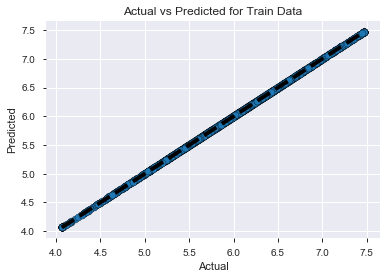

In [78]:
fig, ax = plt.subplots()
ax.scatter(train_Y,  gscv_gbmr.predict(train_X), edgecolors = (0, 0, 0))
ax.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

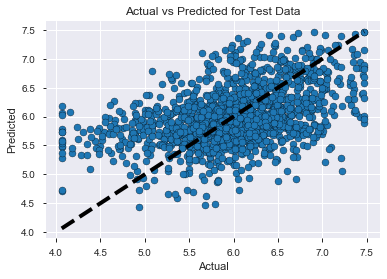

In [79]:
fig, ax = plt.subplots()
ax.scatter(test_Y, gscv_gbmr.predict(test_X), edgecolors=(0, 0, 0))
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

## Support Vector Regression (SVR)

In [82]:
from sklearn.svm import SVR

In [93]:
#making the data scale free for distance based learning
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
X_scaled=pd.DataFrame(sc.fit_transform(X))

X_scaled

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,-0.934162,-1.323175,-1.520979,1.134986,0.629490,-0.951571,1.042920,-0.362852,-0.751628,0.241225,...,-1.465464,1.050051,1.003167,-0.447252,-0.481522,1.516684,0.964625,-0.606313,-0.553660,-0.440858
1,1.070478,-1.161836,-1.408420,-1.276287,0.629490,1.050893,-0.958846,-0.362852,-0.751628,-0.602809,...,0.035068,-0.952335,-0.831132,-0.623330,1.622418,1.516684,-1.036672,1.649314,1.846524,1.369578
2,-0.934162,1.096913,1.124143,1.134986,0.629490,-0.951571,-0.958846,-0.362852,1.330445,-0.602809,...,1.182534,-0.952335,-0.831132,-0.623330,0.921105,-0.659333,-1.036672,-0.606313,-0.553660,-0.440858
3,1.070478,-1.081166,-1.352141,-1.276287,0.629490,-0.951571,-0.958846,-0.362852,1.330445,-0.602809,...,-0.097332,-0.952335,-0.831132,-0.623330,0.219792,-0.659333,-1.036672,-0.606313,-0.553660,-0.440858
4,1.070478,-1.081166,-1.183304,1.134986,0.629490,1.050893,1.042920,-0.362852,1.330445,1.085259,...,-0.759331,1.050051,0.212521,-0.199453,-0.481522,1.516684,-1.036672,1.649314,0.447950,0.000903
5,-0.934162,1.177582,0.955305,1.134986,0.629490,1.050893,1.042920,-2.004715,-0.751628,-0.602809,...,-0.450398,1.050051,0.860850,0.171070,0.921105,-0.659333,-1.036672,-0.606313,-0.553660,-0.440858
6,-0.934162,0.370887,0.279955,-0.070650,-1.588587,-0.951571,-0.958846,1.279012,-0.751628,1.929293,...,-1.024131,-0.952335,-0.831132,-0.623330,1.622418,-0.659333,-1.036672,-0.606313,-0.553660,-0.440858
7,-0.934162,0.290217,-0.170278,1.134986,0.629490,1.050893,1.042920,-0.362852,1.330445,-1.446843,...,0.344001,1.050051,0.686908,0.590683,0.921105,-0.659333,0.964625,-0.606313,-0.553660,-0.440858
8,1.070478,0.370887,1.067864,1.134986,0.629490,-0.951571,-0.958846,-0.362852,-0.751628,0.241225,...,0.652935,-0.952335,-0.831132,-0.623330,0.219792,-0.659333,0.964625,-0.606313,-0.553660,-0.440858
9,1.070478,0.209547,-0.001441,1.134986,-1.588587,-0.951571,-0.958846,1.279012,-0.751628,1.929293,...,-1.553731,-0.952335,-0.831132,-0.623330,-0.481522,-0.659333,0.964625,-0.606313,-0.553660,-0.440858


In [112]:
train_X, test_X, train_Y, test_Y = train_test_split(X_scaled, Y, test_size=0.3, random_state=8945)

In [113]:
#Search best model param 
svr = SVR()

para = {'C' : [1, 10, 100,150],
              'gamma': [10 ** x for x in range(-10, -5)],
              'epsilon':[0.1,0.5]}

svr = GridSearchCV(svr ,para, cv = 5)
grid_result = svr.fit(train_X, train_Y)

In [114]:
svr.best_params_

{'C': 150, 'epsilon': 0.1, 'gamma': 1e-06}

In [115]:
svr.best_score_

0.1701281986343666

In [116]:
#build the model based on best params found
svr = SVR(C = 150, gamma = 1e-06, epsilon = 0.1)
svr.fit(train_X, train_Y)

SVR(C=150, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-06,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [117]:
score = cross_val_score(svr, train_X, train_Y, cv = 5, scoring = 'r2')
score

array([0.15278988, 0.17893984, 0.16509478, 0.17447147, 0.17934502])

In [118]:
np.mean(score)

0.1701281986343666

In [119]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, svr.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, svr.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, svr.predict(test_X))))

Mean Absolute Error: 0.4570630957083138
Mean Squared Error: 0.3493711741888895
Root Mean Squared Error: 0.5910762845766099


In [120]:
print("R-squared for Train:" ,svr.score(train_X, train_Y))
print("R-squared for Test: ", svr.score(test_X, test_Y))

R-squared for Train: 0.19276728205265617
R-squared for Test:  0.17203481859612701


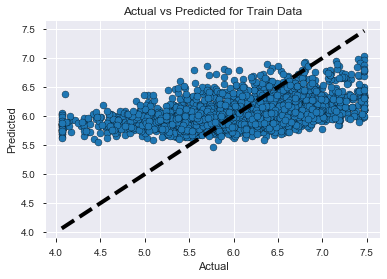

In [121]:
fig, ax = plt.subplots()
ax.scatter(train_Y, svr.predict(train_X), edgecolors = (0, 0, 0))
ax.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

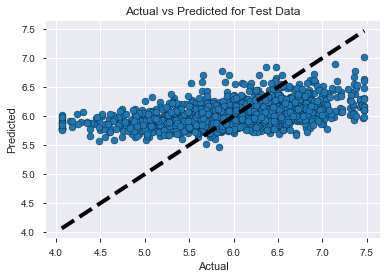

In [122]:
fig, ax = plt.subplots()
ax.scatter(test_Y, svr.predict(test_X), edgecolors=(0, 0, 0))
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

## K-Nearest Neighbor (KNN)

In [105]:
from sklearn.neighbors import KNeighborsRegressor

In [123]:
tuned_parameters = [{'n_neighbors': [10,15,20,25,30,35,40,45,50,55,60,65,70,75]}]

knn = GridSearchCV(KNeighborsRegressor(),
                   tuned_parameters,
                   cv=5,
                   n_jobs=-1)

In [124]:
knn.fit(X_train, y_train )

knn.best_score_

0.08796789791362161

In [125]:
knn.best_params_

{'n_neighbors': 65}

In [127]:
#build the model based on best param
KNN = KNeighborsRegressor(n_neighbors = 65)
KNN.fit(train_X, train_Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=65, p=2,
                    weights='uniform')

In [128]:
scores = cross_val_score(KNN, train_X, train_Y, cv = 10, scoring = 'r2')
scores

array([0.06745543, 0.07425087, 0.0823867 , 0.09293327, 0.09086509,
       0.08912443, 0.08586423, 0.0912648 , 0.09180013, 0.10988689])

In [129]:
np.mean(scores)

0.08758318557020334

In [130]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, KNN.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, KNN.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, KNN.predict(test_X))))

Mean Absolute Error: 0.486323873870517
Mean Squared Error: 0.3872865841722518
Root Mean Squared Error: 0.622323536572619


In [131]:
print("R-squared for Train:",KNN.score(train_X, train_Y))
print("R-squared for Test:",KNN.score(test_X, test_Y))

R-squared for Train: 0.11653275447737389
R-squared for Test: 0.08218012644025907


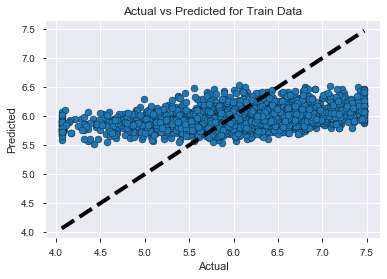

In [132]:
fig, ax = plt.subplots()
ax.scatter(train_Y, KNN.predict(train_X), edgecolors = (0, 0, 0))
ax.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

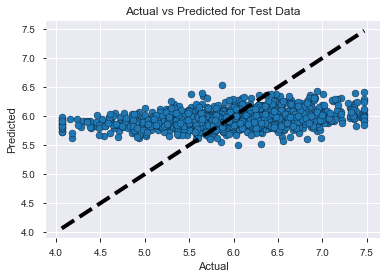

In [133]:
fig, ax = plt.subplots()
ax.scatter(test_Y, KNN.predict(test_X), edgecolors = (0, 0, 0))
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()